In [1]:
import btrdb
import numpy as np
import pandas as pd
import time
from datetime import datetime
from datetime import timedelta
from matplotlib.pyplot import cm

import scipy.signal as sig
from scipy import linalg
from scipy.ndimage.interpolation import shift


from tabulate import tabulate
from btrdb.utils.timez import ns_delta
from btrdb.utils.timez import ns_delta, to_nanoseconds
from btrdb.utils.timez import ns_to_datetime
from btrdb.utils.general import pointwidth

import importlib

# Plotting
import matplotlib.pyplot as plt
#plt.style.use('Solarize_Light2')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Some useful functions for visualization. 
# Converts a phasor into a time domain signal.
# INPUTS
# phasor [complex number]
# T [array] time points at which to determine time domain signal values
# f [default value = 2] frequency of time domain signal.
# Using true 60 Hz value makes visualization difficult, so I use a fake, small frequency
# OUTPUTS
# x [array] time domain signal
def phasor_to_time(phasor, T, f=2):
    # phasor - Complex number representing phasor
    # Get amplitude from RMS magnitude
    A = np.abs(phasor) * np.sqrt(2)
    # Get angle
    theta = np.angle(phasor); 
    # Return time domain
    x = A*np.cos(2*np.pi*f*T + theta); 
    return x

# Plots a set of phasors in the complex plane
# phasor_list [list of complex numbers] list of phasors to plot
# names [list of strings] list of labels for each phasor to put in legend
# c [list of strings] specifies color for each phasor
# title [string] Title for plot
def plot_phasor(phasor_list, names, c, title, fig, num):
    N = len(phasor_list);
    
    # Initialize figure
    #fig = plt.figure(); 
    ax = fig.add_subplot(num, projection='polar')
    # Keep track of longest phasor for sizing plot
    max_r = 1; 
    arrows = []
    # Iterate through phasors
    for i in range(N):
        phasor = phasor_list[i];
        mag = np.abs(phasor); theta = np.angle(phasor); 
        # Update longest phasor
        if mag > max_r: max_r = mag; 
        # Plot phasor
        a = ax.arrow(theta, 0, 0, mag, linewidth=3, color=c[i], length_includes_head=True, label=names[i])
        arrows.append(a);
    # Set size of polar plot to be slightly larger than longest phasor
    ax.set_rmax(max_r + 0.1)

    plt.legend(arrows, names);
    plt.title(title, fontsize=20)

# Convert a list of phasors to time domain signals
# INPUTS
# phasor_list [list of complex numbers] phasors to convert to time domain
# OUTPUTS
# time_sigs [list of arrays] list of time domain signals
def timedomain(phasor_list):
    time_sigs = [];
    T = np.arange(0, 5, 0.001); 
    for phasor in phasor_list:
        time_sigs.append(phasor_to_time(phasor, T));
    return time_sigs
    
# Plot a set of time domain signals 
# time_sigs [list of array] list of time domain signals to plot
# names [list of strings] list of labels for each signal to put in legend
# c [list of strings] specifies color for each signal
# title [string] Title for plot
def plot_time(time_sigs, names, c, title):
    plt.figure(figsize=(15, 3));
    N = len(time_sigs);
    for i in range(N):
        plt.plot(time_sigs[i], lw=3, label=names[i], color=c[i])
    plt.legend(fontsize=16); plt.title(title, fontsize=20); 
    
def getPolar(x, deg=False):
    mag = np.abs(x); 
    angle = np.angle(x); 
    if deg:
        angle = angle*(180/np.pi); 
    return mag, angle

def getRect(mag, angle, deg=False):
    if deg:
        angle = angle*(np.pi/180); 
    real = mag*np.cos(angle); imag = mag*np.sin(angle); 
    return real + 1j*imag; 
    
# Colors for phases
phase_colors = ['r', 'g', 'b'];

### Symmetrical Components Definition
Phase a,b,c to symmetrical components
$$
\alpha = e^{j\frac{2\pi}{3}}\\
\begin{bmatrix} I_{0} \\ I_{+} \\ I_{-} \end{bmatrix} = \frac{1}{3}\begin{bmatrix} 1 & 1 & 1\\ 1 & \alpha & \alpha^2 \\ 1 & \alpha^2 & \alpha\end{bmatrix}\begin{bmatrix}I_a \\ I_b \\ I_c\end{bmatrix}
$$
Symmetrical components to Phase a,b,c
$$
\begin{bmatrix} I_{a} \\ I_{b} \\ I_{c} \end{bmatrix} = \frac{1}{3}\begin{bmatrix} 1 & 1 & 1\\ 1 & \alpha^2 & \alpha \\ 1 & \alpha & \alpha^2\end{bmatrix}\begin{bmatrix}I_{0} \\ I_{+} \\ I_{-}\end{bmatrix}
$$

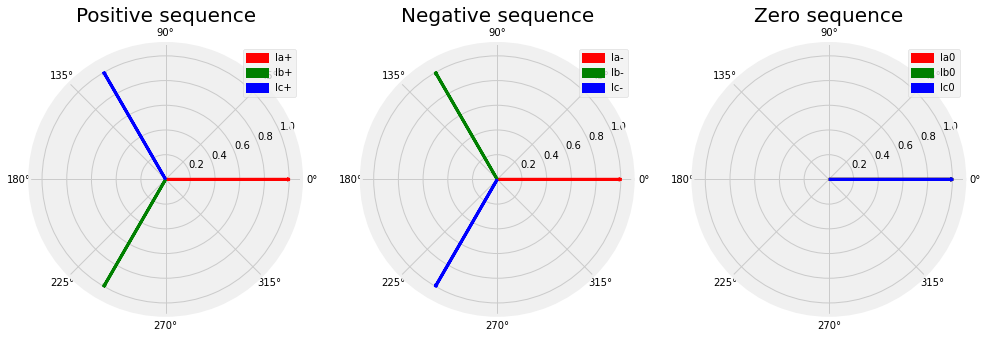

In [3]:
# Positive
fig = plt.figure(figsize=(15, 5)); 

Ipa = getRect(1, 0, deg=True); Ipb = getRect(1, -120, deg=True); Ipc = getRect(1, -240, deg=True);
plot_phasor([Ipa, Ipb, Ipc],['Ia+', 'Ib+', 'Ic+'],phase_colors,'Positive sequence', fig, 131); 

# Negative
Ina = getRect(1, 0, deg=True); Inb = getRect(1, 120, deg=True); Inc = getRect(1, 240, deg=True);
plot_phasor([Ina, Inb, Inc],['Ia-', 'Ib-', 'Ic-'],phase_colors,'Negative sequence', fig, 132);

# Zero
I0a = getRect(1, 0, deg=True); I0b = getRect(1, 0, deg=True); I0c = getRect(1, 0, deg=True);
plot_phasor([I0a, I0b, I0c],['Ia0', 'Ib0', 'Ic0'],phase_colors,'Zero sequence', fig, 133);

plt.savefig('sym_comps', dpi=200);

### Symmetrical Components Example

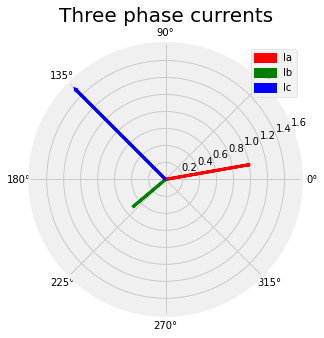

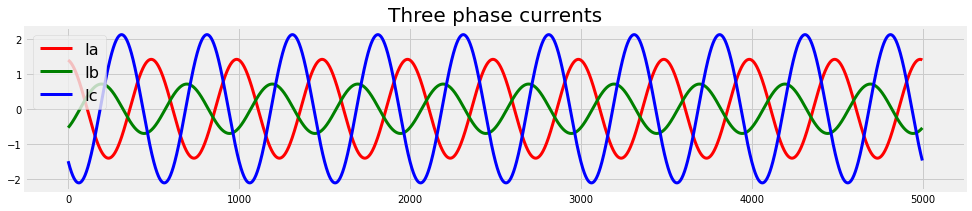

In [4]:
fig = plt.figure(figsize=(5, 5));
IA = getRect(1, 10, deg=True); 
IB = getRect(0.5, -140, deg=True); 
IC = getRect(1.5, 135, deg=True); 
plot_phasor([IA, IB, IC],['Ia', 'Ib', 'Ic'],phase_colors,'Three phase currents', fig, 111);
plt.savefig('phase_currents', dpi=200);

Itime = timedomain([IA, IB, IC]);
plot_time(Itime, ['Ia', 'Ib', 'Ic'],phase_colors,'Three phase currents');
plt.savefig('phase_currents_td', dpi=200);

### Computing Symmetrical Components

In [5]:
def symComps(Va, Vb, Vc):
    a = np.exp(1j*(2*np.pi/3))
    V1 = (1/3)*(Va + a*Vb + (a**2)*Vc)
    V2 = (1/3)*(Va + (a**2)*Vb + a*Vc)
    V0 = (1/3)*(Va + Vb + Vc)
    return V0, V1, V2
    
def phaseComps(V0, V1, V2):
    Va = V0 + V1 + V2
    Vb = (a**2)*V1 + a*V2 + V0
    Vc = a*V1 + (a**2)*V2 + V0
    return Va, Vb, Vc

def allSymComps(Va, Vb, Vc):
    a = np.exp(1j*(2*np.pi/3))
    V0, V1, V2 = symComps(Va, Vb, Vc); 
    pos = [V1, (a**2)*V1, a*V1];
    neg = [V2, a*V2, (a**2)*V2];
    zero = [V0, V0, V0]; 
    return pos, neg, zero

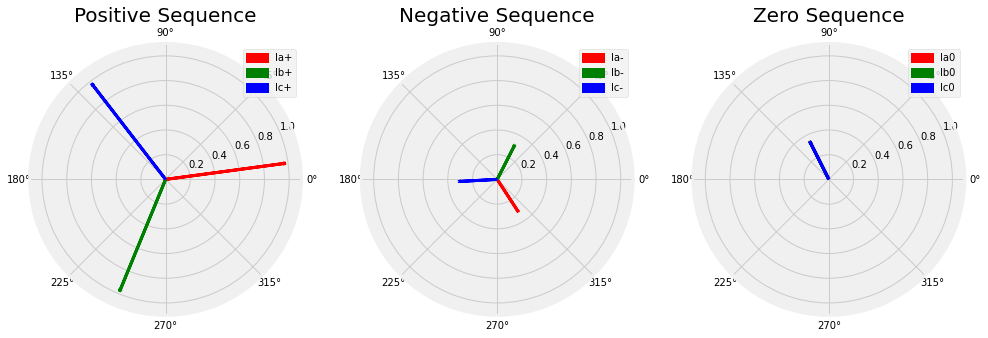

In [6]:
pos, neg, zero = allSymComps(IA, IB, IC); 
fig = plt.figure(figsize=(15, 5)); 

plot_phasor(pos,['Ia+', 'Ib+', 'Ic+'],phase_colors,'Positive Sequence', fig, 131);
plot_phasor(neg,['Ia-', 'Ib-', 'Ic-'],phase_colors,'Negative Sequence', fig, 132);
plot_phasor(zero,['Ia0', 'Ib0', 'Ic0'],phase_colors,'Zero Sequence', fig, 133);

plt.savefig('sym_currents', dpi=200)

In [7]:
def plotSym(Va, Vb, Vc, fig=None, num=111):
    V0, V1, V2 = symComps(Va, Vb, Vc);
    a = np.exp(1j*(2*np.pi/3))
    if fig is None:
        fig = plt.figure(); 
        
    ax = fig.add_subplot(num, projection='polar')
    ### Plot Va components
    # Pos
    V1ang = np.angle(V1); V1mag = np.abs(V1)
    pos = ax.arrow(V1ang, 0, 0, V1mag, linestyle='dotted', linewidth=3, color='red', length_includes_head=True)
    # Neg
    V2ang = np.angle(V1 + V2); V2mag = np.abs(V1 + V2)
    neg = ax.arrow(V1ang, V1mag, V2ang-V1ang, V2mag-V1mag, linestyle='dotted', linewidth=3, color='red', length_includes_head=True)
    # Zero
    V0ang = np.angle(V1 + V2 + V0); V0mag = np.abs(V1 + V2 + V0)
    zero = ax.arrow(V2ang, V2mag, V0ang-V2ang, V0mag-V2mag, linestyle='dotted', linewidth=3, color='red', length_includes_head=True)
    # Va
    Vaang = np.angle(Va); Vamag = np.abs(Va)
    pca = ax.arrow(Vaang, 0, 0, Vamag, linewidth=3, color='red', length_includes_head=True)
    
    ### Plot Vb components
    V1b = (a**2)*V1; V2b = a*V2;
    # Pos
    V1ang = np.angle(V1b); V1mag = np.abs(V1b)
    ax.arrow(V1ang, 0, 0, V1mag, linestyle='dotted', linewidth=3, color='green', length_includes_head=True)
    # Neg
    V2ang = np.angle(V1b + V2b); V2mag = np.abs(V1b + V2b)
    ax.arrow(V1ang, V1mag, V2ang-V1ang, V2mag-V1mag, linestyle='dotted', linewidth=3, color='green', length_includes_head=True)
    # Zero
    V0ang = np.angle(V1b + V2b + V0); V0mag = np.abs(V1b + V2b + V0)
    ax.arrow(V2ang, V2mag, V0ang-V2ang, V0mag-V2mag, linestyle='dotted', linewidth=3, color='green', length_includes_head=True)
    # Va
    Vaang = np.angle(Vb); Vamag = np.abs(Vb)
    pcb = ax.arrow(Vaang, 0, 0, Vamag, linewidth=3, color='green', length_includes_head=True)
    
    
    ### Plot Vc components
    V1c = a*V1; V2c = (a**2)*V2;
    # Pos
    V1ang = np.angle(V1c); V1mag = np.abs(V1c)
    ax.arrow(V1ang, 0, 0, V1mag, linestyle='dotted', linewidth=3, color='blue', length_includes_head=True)
    # Neg
    V2ang = np.angle(V1c + V2c); V2mag = np.abs(V1c + V2c)
    ax.arrow(V1ang, V1mag, V2ang-V1ang, V2mag-V1mag, linestyle='dotted', linewidth=3, color='blue', length_includes_head=True)
    # Zero
    V0ang = np.angle(V1c + V2c + V0); V0mag = np.abs(V1c + V2c + V0)
    ax.arrow(V2ang, V2mag, V0ang-V2ang, V0mag-V2mag, linestyle='dotted', linewidth=3, color='blue', length_includes_head=True)
    # Va
    Vaang = np.angle(Vc); Vamag = np.abs(Vc)
    pcc = ax.arrow(Vaang, 0, 0, Vamag, linewidth=3, color='blue', length_includes_head=True)
    
    ax.set_rmax(max(np.abs(Va), np.abs(Vb), np.abs(Vc))+0.1)
    ax.set_title('Phase and Symmetrical Components', fontdict = {'fontsize':28}); 
    ax.legend([pca, pcb, pcc], ['Ia', 'Ib', 'Ic'],  fontsize=25)

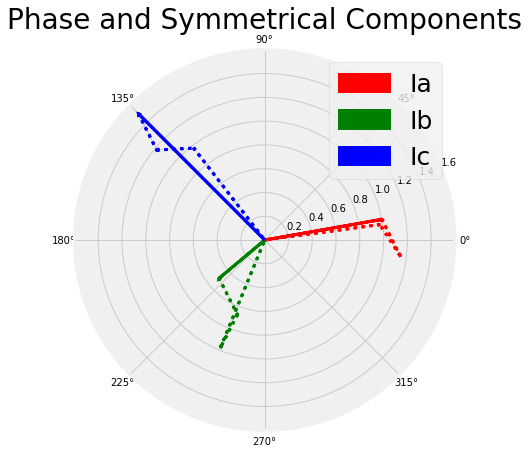

In [8]:
fig = plt.figure(figsize=(7, 7)); 
plotSym(IA, IB, IC, fig=fig)
plt.savefig('sym_inverse', dpi=200)

## Compute Symmetrical Components on Real Data

In [9]:
# Gets window of data around point
def get_data(stream, time, window = timedelta(seconds=1), version=0):
    points, _ = zip(*stream.values(time-window, time+window, version)); 
    T = len(points); 
    values = np.zeros(T);
    
    for i in range(T):
        values[i] = points[i][1]
    
    return values

In [10]:
# Insert your API key here!
APIKEY= 'YOUR API KEY'

db = btrdb.connect("api.ni4ai.org:4411", apikey=APIKEY)
db.info()

{'majorVersion': 5, 'build': '5.11.37', 'proxy': {'proxyEndpoints': []}}

In [11]:
# Get voltage streams
uuids = db.query("SELECT collection, name FROM streams WHERE collection like 'sunshine/PMU1'")
print(uuids)
uuids = [row["collection"]+"/"+row["name"] for row in uuids]

streams = db.streams(*uuids)

[{'collection': 'sunshine/PMU1', 'name': 'LSTATE'}, {'collection': 'sunshine/PMU1', 'name': 'C1ANG'}, {'collection': 'sunshine/PMU1', 'name': 'C3MAG'}, {'collection': 'sunshine/PMU1', 'name': 'C2MAG'}, {'collection': 'sunshine/PMU1', 'name': 'C1MAG'}, {'collection': 'sunshine/PMU1', 'name': 'C3ANG'}, {'collection': 'sunshine/PMU1', 'name': 'L3ANG'}, {'collection': 'sunshine/PMU1', 'name': 'L2ANG'}, {'collection': 'sunshine/PMU1', 'name': 'L3MAG'}, {'collection': 'sunshine/PMU1', 'name': 'L1ANG'}, {'collection': 'sunshine/PMU1', 'name': 'C2ANG'}, {'collection': 'sunshine/PMU1', 'name': 'L1MAG'}, {'collection': 'sunshine/PMU1', 'name': 'L2MAG'}]


In [12]:
l1mag_uuid = streams[11]; l3mag_uuid = streams[12]; l2mag_uuid = streams[8]; 
l1ang_uuid = streams[9]; l3ang_uuid = streams[7]; l2ang_uuid = streams[6]; 

In [13]:
t = datetime(2015, 10, 31, 23, 55, 59, 342380)
dt = timedelta(seconds=60*5);

# Get magnitudes
l1mag = get_data(l1mag_uuid, t, window=dt);
l2mag = get_data(l2mag_uuid, t, window=dt);
l3mag = get_data(l3mag_uuid, t, window=dt);
# Get angles (wrapped)
l1ang_w = get_data(l1ang_uuid, t, window=dt);
l2ang_w = get_data(l2ang_uuid, t, window=dt);
l3ang_w = get_data(l3ang_uuid, t, window=dt);

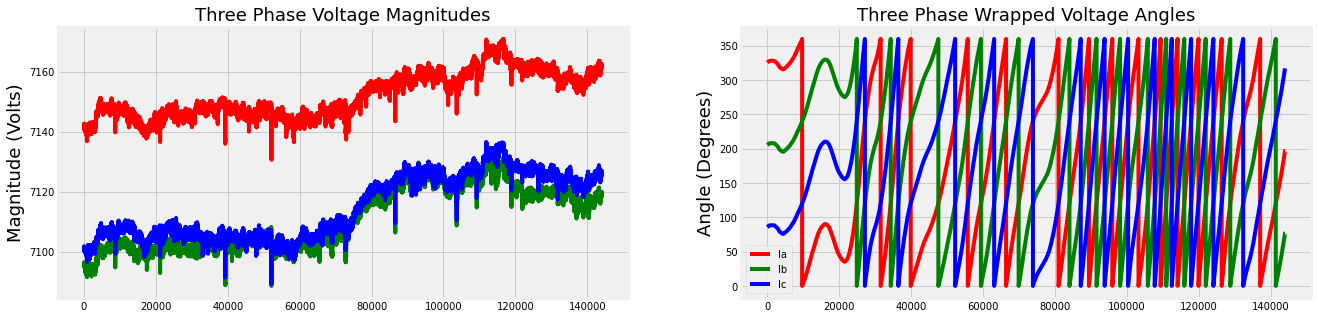

In [14]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title('Three Phase Voltage Magnitudes', fontsize=18)
plt.plot(l1mag, label='Ia', color='red')
plt.plot(l2mag, label='Ib', color='green')
plt.plot(l3mag, label='Ic', color='blue')
plt.ylabel('Magnitude (Volts)', fontsize=18)

plt.subplot(1, 2, 2)
plt.title('Three Phase Wrapped Voltage Angles', fontsize=18);
plt.plot(l1ang_w, label='Ia', color='red')
plt.plot(l2ang_w, label='Ib', color='green')
plt.plot(l3ang_w, label='Ic', color='blue')
plt.ylabel('Angle (Degrees)', fontsize=18)
plt.legend();

# Unwrap angles
l1ang = np.unwrap(l1ang_w*(np.pi/180))
l2ang = np.unwrap(l2ang_w*(np.pi/180))
l3ang = np.unwrap(l3ang_w*(np.pi/180))

#plt.savefig('voltage_data', dpi=200)

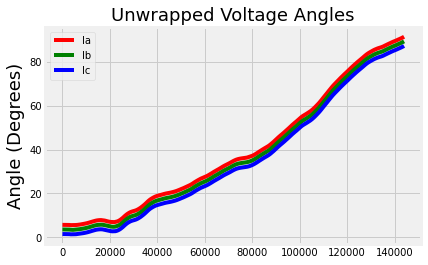

In [15]:
# Plot the results
plt.figure(); plt.title('Unwrapped Voltage Angles', fontsize=18);
plt.ylabel('Angle (Degrees)', fontsize=18)
plt.plot(l1ang, label='Ia', color='red')
plt.plot(l2ang, label='Ib', color='green')
plt.plot(l3ang, label='Ic', color='blue')
plt.legend();
#plt.savefig('unwrapped_angle', dpi=200)

In [16]:
# Get phasors
Ia = l1mag*np.exp(1j*l1ang)
Ib = l2mag*np.exp(1j*l2ang)
Ic = l3mag*np.exp(1j*l3ang)
# Get symmetrical components
pos, neg, zero = allSymComps(Ia, Ib, Ic); 

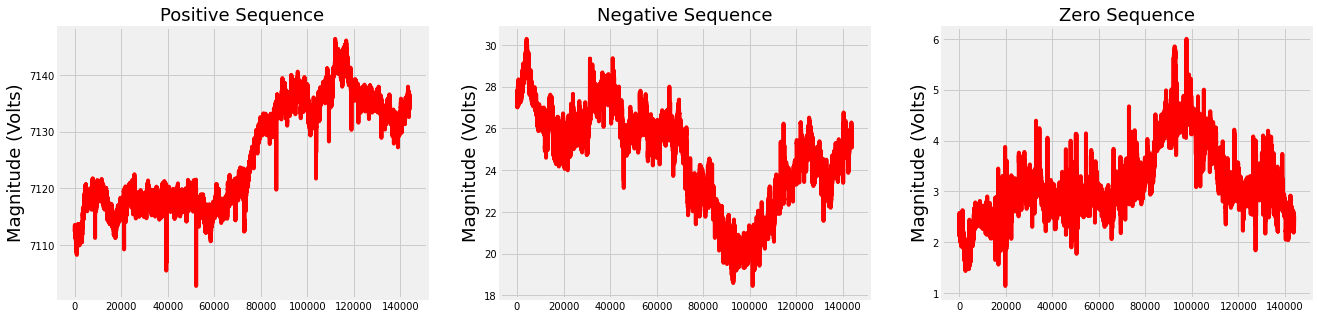

In [17]:
plt.figure(figsize=(20, 5)); 

plt.subplot(1, 3, 1)
plt.plot(np.abs(pos[0]), color='red')
plt.title('Positive Sequence', fontsize=18);
plt.ylabel('Magnitude (Volts)', fontsize=18);

plt.subplot(1, 3, 2)
plt.plot(np.abs(neg[0]), color='red')
plt.title('Negative Sequence', fontsize=18);
plt.ylabel('Magnitude (Volts)', fontsize=18);

plt.subplot(1, 3, 3)
plt.plot(np.abs(zero[0]), color='red')
plt.title('Zero Sequence', fontsize=18);
plt.ylabel('Magnitude (Volts)', fontsize=18);

plt.savefig('voltage_sym_comps', dpi=200)

## Symmetrical Components during Event

In [18]:
t = datetime(2016, 3, 15, 23, 26, 23)
dt = timedelta(seconds=60*5);

# Get magnitudes
l1mag = get_data(l1mag_uuid, t, window=dt);
l2mag = get_data(l2mag_uuid, t, window=dt);
l3mag = get_data(l3mag_uuid, t, window=dt);
# Get angles (wrapped)
l1ang_w = get_data(l1ang_uuid, t, window=dt);
l2ang_w = get_data(l2ang_uuid, t, window=dt);
l3ang_w = get_data(l3ang_uuid, t, window=dt);

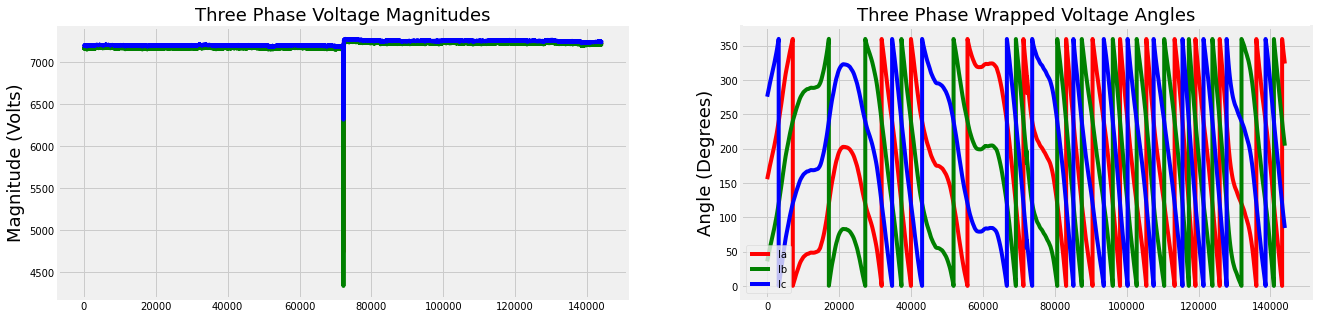

In [19]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title('Three Phase Voltage Magnitudes', fontsize=18)
plt.plot(l1mag, label='Ia', color='red')
plt.plot(l2mag, label='Ib', color='green')
plt.plot(l3mag, label='Ic', color='blue')
plt.ylabel('Magnitude (Volts)', fontsize=18)

plt.subplot(1, 2, 2)
plt.title('Three Phase Wrapped Voltage Angles', fontsize=18);
plt.plot(l1ang_w, label='Ia', color='red')
plt.plot(l2ang_w, label='Ib', color='green')
plt.plot(l3ang_w, label='Ic', color='blue')
plt.ylabel('Angle (Degrees)', fontsize=18)
plt.legend();

# Unwrap angles
l1ang = np.unwrap(l1ang_w*(np.pi/180))
l2ang = np.unwrap(l2ang_w*(np.pi/180))
l3ang = np.unwrap(l3ang_w*(np.pi/180))

plt.savefig('voltage_event_data', dpi=200)

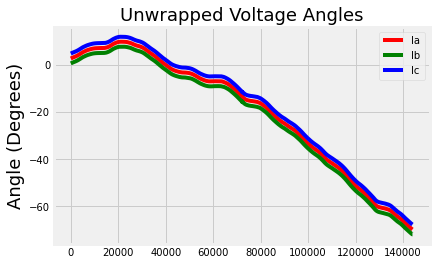

In [20]:
# Plot the results
plt.figure(); plt.title('Unwrapped Voltage Angles', fontsize=18);
plt.ylabel('Angle (Degrees)', fontsize=18)
plt.plot(l1ang, label='Ia', color='red')
plt.plot(l2ang, label='Ib', color='green')
plt.plot(l3ang, label='Ic', color='blue')
plt.legend();

plt.savefig('unwrapped_angle_event', dpi=200)

In [21]:
# Get phasors
Ia = l1mag*np.exp(1j*l1ang)
Ib = l2mag*np.exp(1j*l2ang)
Ic = l3mag*np.exp(1j*l3ang)
# Get symmetrical components
pos, neg, zero = allSymComps(Ia, Ib, Ic); 

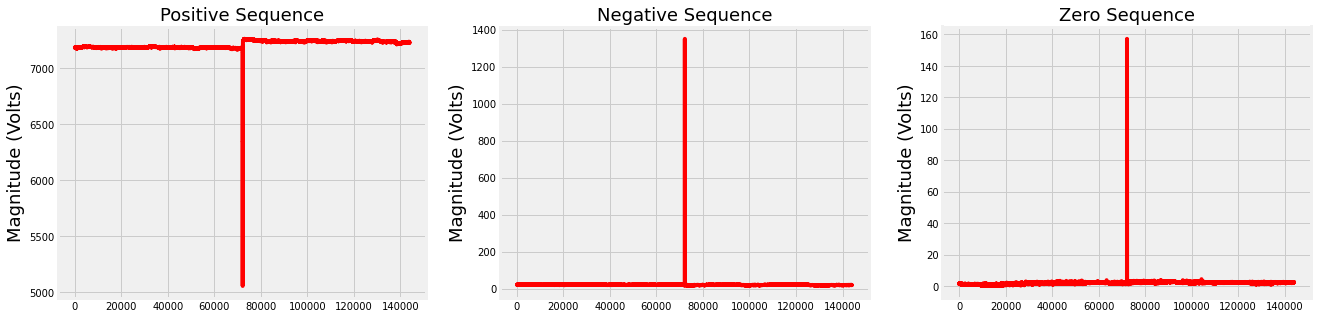

In [22]:
plt.figure(figsize=(20, 5)); 

plt.subplot(1, 3, 1)
plt.plot(np.abs(pos[0]), color='red')
plt.title('Positive Sequence', fontsize=18);
plt.ylabel('Magnitude (Volts)', fontsize=18);

plt.subplot(1, 3, 2)
plt.plot(np.abs(neg[0]), color='red')
plt.title('Negative Sequence', fontsize=18);
plt.ylabel('Magnitude (Volts)', fontsize=18);

plt.subplot(1, 3, 3)
plt.plot(np.abs(zero[0]), color='red')
plt.title('Zero Sequence', fontsize=18);
plt.ylabel('Magnitude (Volts)', fontsize=18);

plt.savefig('voltage_sym_comps_event', dpi=200)